In [11]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import mvn, norm
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*'))
from IPython.core.pylabtools import figsize
figsize(15, 4)
pd.options.display.max_colwidth = 60
from pprint import pprint

def np_cdf(mean, diag_sigma, value, name=None):
    low = np.array([-30, -30])
    cdf = list()
    for s in value:
        # mvn.mvnun(low, upp, mean, cov)
        p, _ = mvn.mvnun(low, upper=s, covar=diag_sigma, means=mean)
        cdf.append(p)
    cdfs = np.asarray(cdf, dtype=np.float32).reshape([-1, 1])
    return cdfs

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


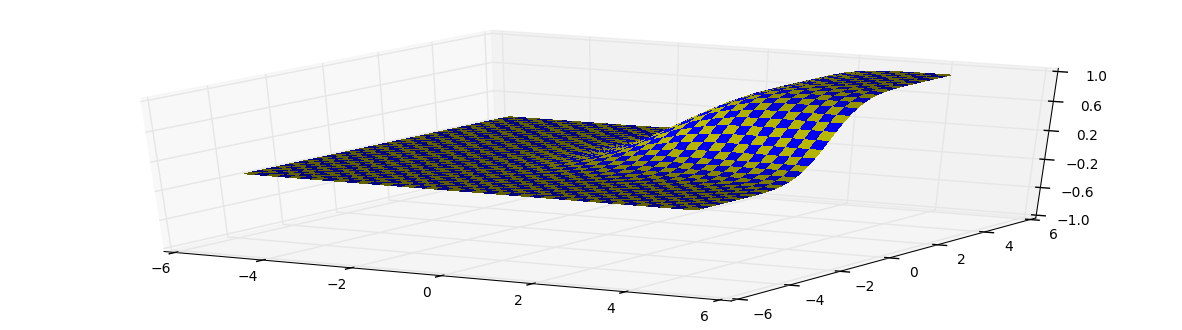

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt
import numpy as np


low = np.array([-10, -10])
upp = np.array([.1, -.2])
mean = np.array([0, 1])
cov = np.array([(1, .5), (.5, 1)])

fig = plt.figure()
ax = fig.gca(projection='3d')
X0 = np.arange(-5, 5, 0.25)
xlen = len(X0)
Y0 = np.arange(-5, 5, 0.25)
ylen = len(Y0)
X, Y = np.meshgrid(X0, Y0)
data = cartesian(arrays=[X0, Y0])
# init(data, low, upp, 5, 20)
Z = np_cdf(mean=mean, diag_sigma=cov, value=data, name=None).reshape([xlen,ylen])

colortuple = ('y', 'b')
colors = np.empty(X.shape, dtype=str)
for y in range(ylen):
    for x in range(xlen):
        colors[x, y] = colortuple[(x + y) % len(colortuple)]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors,
                       linewidth=0, antialiased=False)

ax.set_zlim3d(-1, 1)
ax.w_zaxis.set_major_locator(LinearLocator(6))

plt.show()

# Question

I am reviewing this Tuesday’s slide. In page 11(lecture 9), the tranche notional is calculated as J(K1,K2)=Q(K1,K2,T)*(K2-K1). I do not quite understand what this notional mean. 

According to page 9, tranche notional loss = E[min(LT,K2)]-E[min(LT,K1)]. Is this notional the same one as J(K1,K2)?

If they are the same, then J(K1,K2)=[1-Q(K1,K2,T)] * (K2-K1), by using Q(K1,K2,T) = 1-{E[min(LT,K2)]-E[min(LT,K1)] / (K2-K1)}. Is this right?

In [14]:
R=0.4
PD= 0.05 # Probability of default per year 
PD = np.array([0.05*x for x in range(1,100) ]) # Probability of default per year
beta = 0.3
CT = norm.ppf(PD)
x = 0.5

In [15]:
def AA(CT,x,R):
    AAA = CT - np.sqrt(1-beta*beta)*norm.ppf(x/(1-R))
    AAA[AAA < -10]=-10
    AAA[AAA > 10] = 10
    return AAA

# Notice that Emin is multiplied by the total notional of the tranche K!!!!
# $AA(K)) = \frac{C(T)-\sqrt({1-\beta^2})\phi(\frac{K}{(1-R)})}{\beta}$
# $E[min(L_T,K)] = K*[(1-R)*\Phi_2^{-1}(C(T),-AA(K),-\beta)+\Phi(AA(K)]$

In [16]:
def Emin(K,R,CT,beta):
    mean=np.array([0,0])
    cov = np.array([[1,-beta],[-beta,1]])
    AAK = AA(CT=CT,x=K,R=R)
    upp = np.array([(x,y) for x,y in zip(CT,-AAK)])
    A = np_cdf(mean=mean, diag_sigma=cov, value=upp, name=None)
    A = np.asarray(A, dtype=np.float32).reshape([-1, 1])
    B = norm.cdf(AAK)
    B = np.asarray(B, dtype=np.float32).reshape([-1, 1])
    return K*((1-R)*A + B)

In [17]:
def Q(K1,K2,CT,R,beta):
    QQ1 = Emin(K=K1,R=R,CT=CT,beta=beta)
    QQ2 = Emin(K=K2,R=R,CT=CT,beta=beta)
    QQ =1- (QQ2-QQ1)/(K2-K1)
    return QQ,QQ1,QQ2

In [18]:
K1=0.03
K2 = 0.06
R=0.4
beta=0.3
QQ,QQ1,QQ2= Q(K1,K2,CT,R,beta)

/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/mp74207/anaconda/envs/snow35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


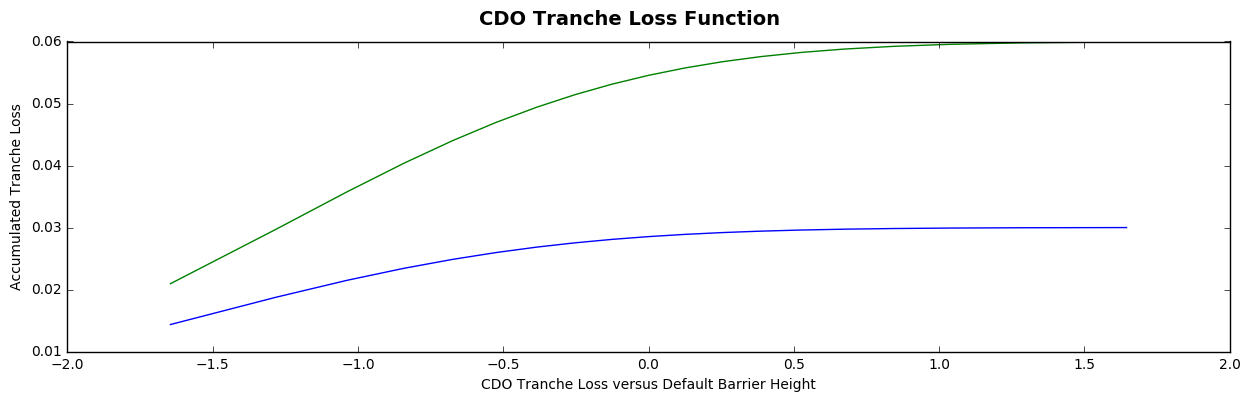

In [19]:
x=CT
fig = plt.figure()
fig.suptitle('CDO Tranche Loss Function', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('CDO Tranche Loss versus Default Barrier Height')
ax.set_ylabel('Accumulated Tranche Loss')
ax.plot(x,QQ1)
ax.plot(x,QQ2)
plt.show()

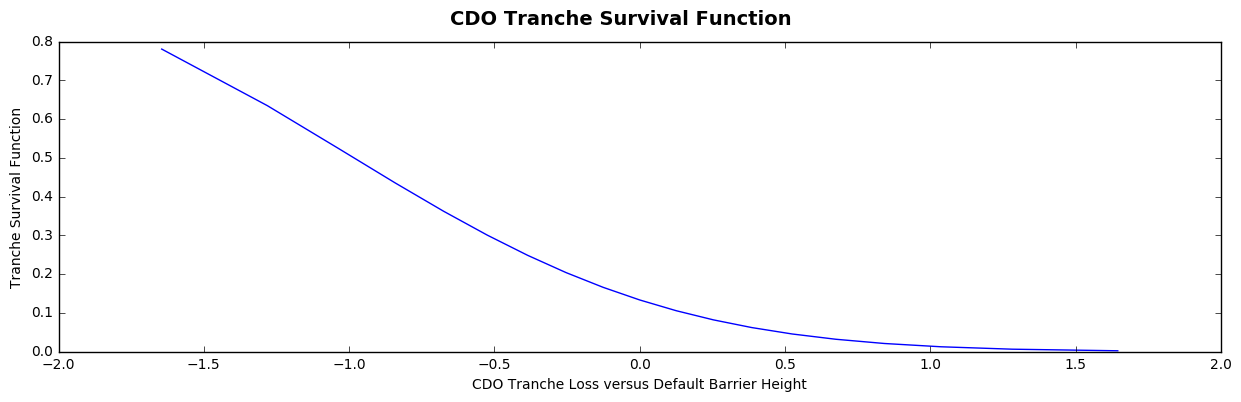

In [20]:
fig = plt.figure()
fig.suptitle('CDO Tranche Survival Function', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('CDO Tranche Loss versus Default Barrier Height')
ax.set_ylabel('Tranche Survival Function')
ax.plot(x,QQ)
plt.show()

# With a survival function one can calculate the CDO spread for a single tenor CDO

## For a multi-tenor CDO one needs to create an array of cashflows and calculate C($T_i$) 
## Notice that this is not what we did above. Here we calculate the survival probability as a function of changing upwards the barrier, that is, making easier to default!!
## C($T_i$) should be an ever decreasing array, since the probality of survival on later years is smaller than the probability of survival in the first year.